In [2]:
import os
os.chdir('02514-Deep-Learning-In-Computer-Vision/hotdog/')

FileNotFoundError: [Errno 2] No such file or directory: '02514-Deep-Learning-In-Computer-Vision/hotdog/'

In [2]:
from dataloader import *
import torch.nn.functional as F
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
from tqdm.notebook import tqdm
import torch.nn as nn


In [3]:
data_train = HotdogDataset()
data_test = HotdogDataset()

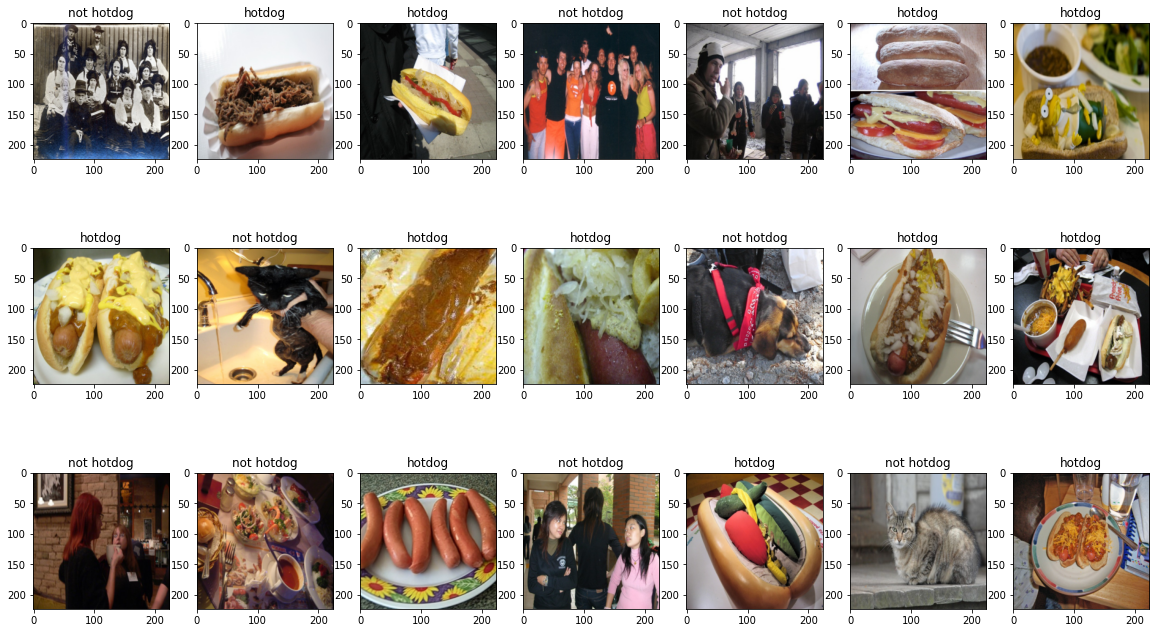

In [48]:
images, labels = next(iter(data_train.get_dataloader(batch_size=21, shuffle=True)))
plt.figure(figsize=(20,20))
for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(images[i].numpy().transpose(1,2,0))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])


In [49]:
len(data_train)

2047

In [50]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In [51]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.convolutional = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=224, kernel_size=3, stride=1, padding=1),
            nn.RelU()
        )

    
    def forward(self, x):
        x = self.convolutional(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        return x
     


In [52]:
model = Network()
model.to(device)
#Initialize the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
# Expand data
train_loader = data_train.get_dataloader()
test_loader = data_test.get_dataloader()
#Get the first minibatch
data = next(iter(train_loader))[0].cuda()
#Try running the model on a minibatch
print('Shape of the output from the convolutional part', model.convolutional(data).shape)
#model(data); #if this runs the model dimensions fit

Shape of the output from the convolutional part torch.Size([32, 224, 224, 224])


In [53]:


num_epochs = 5

for epoch in tqdm(range(num_epochs), unit='epoch'):
    #For each epoch
    train_correct = 0
    model.train()
    for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, target = data.to(device), target.to(device)
        #Zero the gradients computed for each weight
        optimizer.zero_grad()
        #Forward pass your image through the network
        output = model(data)
        #Compute the loss
        loss = F.nll_loss(torch.log(output), target)
        #Backward pass through the network
        loss.backward()
        #Update the weights
        optimizer.step()
        
        #Compute how many were correctly classified
        predicted = output.argmax(1)
        train_correct += (target==predicted).sum().cpu().item()
    #Comput the test accuracy
    test_correct = 0
    model.eval()
    for data, target in test_loader:
        data = data.to(device)
        with torch.no_grad():
            output = model(data)
        predicted = output.argmax(1).cpu()
        test_correct += (target==predicted).sum().item()
    train_acc = train_correct/len(data_train)
    test_acc = test_correct/len(data_test)
    print("Accuracy train: {train:.1f}%\t test: {test:.1f}%".format(test=100*test_acc, train=100*train_acc))
     


  0%|          | 0/5 [00:00<?, ?epoch/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Accuracy train: 51.8%	 test: 48.1%


  0%|          | 0/64 [00:00<?, ?it/s]

Accuracy train: 52.5%	 test: 48.1%


  0%|          | 0/64 [00:00<?, ?it/s]

Accuracy train: 52.5%	 test: 48.1%


  0%|          | 0/64 [00:00<?, ?it/s]